# **NewsAPI Classification and Text Analysis**

**Course:** ADS 509, Applied Large Language Models for Data Science

**Authors:** Christian Lee, Anahit Shekikyan, Graham Ward 

**Date:**

**GitHub:**

**Research Question**

## Setup & Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import re
import html
from collections import Counter
from string import punctuation

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, adjusted_rand_score,
                             normalized_mutual_info_score)
from sklearn.decomposition import NMF

In [2]:
df = pd.read_csv(r"C:\Users\annas\Downloads\articles_clean.csv")
print(df.shape)
df.head()

(3640, 5)


,category,title,description,content,content_len
0,business,"Hasbro leaving Pawtucket for Boston, bringing ...","Hasbro, the century-old company behind childho...","BOSTON —Hasbro, the century-old company behind...",200
1,business,"Meta suppressed children’s safety research, fo...",Four whistleblowers share documents with Congr...,Two current and two former Meta employees disc...,200
2,business,"PNC to buy FirstBank for $4.1B, expanding to A...",PNC Financial plans to buy Colorado-based Firs...,NEW YORK (AP) PNC Financial said Monday that i...,200
3,business,Mortgage rates dive on reports of worsening ec...,One housing economist says the 30-year mortgag...,Mortgage rates are taking a deep dive as finan...,200
4,business,US Steel is shutting down a mill in Illinois. ...,US Steel will stop producing steel at its Gran...,US Steel is shuttering production at a mill in...,200


## Initial Descriptive Stats and Data Exploration

Columns: ['category', 'title', 'description', 'content', 'content_len']
dtypes:
 category       object
title          object
description    object
content        object
content_len     int64
dtype: object 

Rows: 3640
Categories: 7
category
sports           638
science          618
health           610
business         601
technology       474
general          359
entertainment    340
Name: count, dtype: int64

Content length summary:
count    3640.000000
mean      199.062363
std        10.479450
min         4.000000
25%       200.000000
50%       200.000000
75%       200.000000
max       200.000000
Name: content_len, dtype: float64


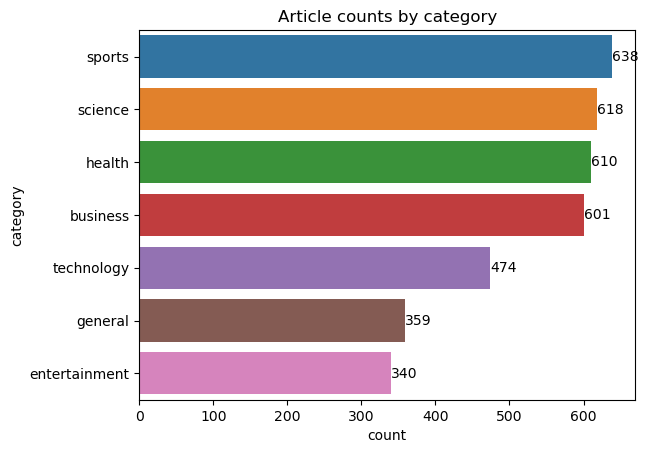

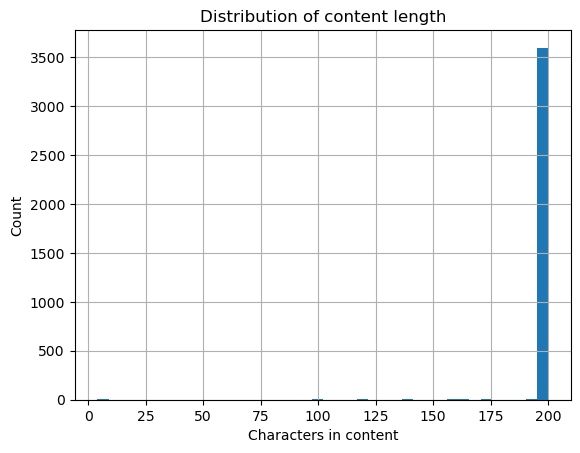

In [3]:
print("Columns:", df.columns.tolist())
print("dtypes:\n", df.dtypes, "\n")
print("Rows:", len(df))
print("Categories:", df['category'].nunique())
print(df['category'].value_counts())

# content length summary
print("\nContent length summary:")
print(df['content_len'].describe())

# category counts
ax = sns.countplot(y="category", data=df, order=df['category'].value_counts().index)
ax.set_title("Article counts by category")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# content length histogram
df['content_len'].hist(bins=40)
plt.title("Distribution of content length")
plt.xlabel("Characters in content")
plt.ylabel("Count")
plt.show()

## Basic text cleanup (data is mostly clean already)

In [4]:
sw = set(stopwords.words("english"))
punct_set = set(punctuation)
ws_pattern = re.compile(r"\s+")

def preclean_text(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ""
    x = html.unescape(s)
    x = re.sub(r"<[^>]+>", " ", x)                # remove HTML tags
    x = re.sub(r"\[\s*\+\s*\d+\s*chars?\s*\]", " ", x)  # remove [+123 chars]
    x = re.sub(r"(…|\.{3,})\s*$", " ", x)         # trailing ellipses
    x = ws_pattern.sub(" ", x).strip()
    return x

def clean_and_tokenize(text: str, stop=sw):
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    text = text.lower()
    text = "".join(ch if ch not in punct_set else " " for ch in text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = ws_pattern.sub(" ", text).strip()
    if not text:
        return []
    toks = text.split()
    return [t for t in toks if t not in stop]

# applying light preclean to text columns
for col in ["title", "description", "content"]:
    df[col] = df[col].fillna("").map(preclean_text)


In [5]:
# view token
df["content_tokens"] = df["content"].apply(clean_and_tokenize)
df["num_tokens"] = df["content_tokens"].apply(len)
print(df[["category","num_tokens"]].head())

   category  num_tokens
0  business          23
1  business          20
2  business          25
3  business          24
4  business          19


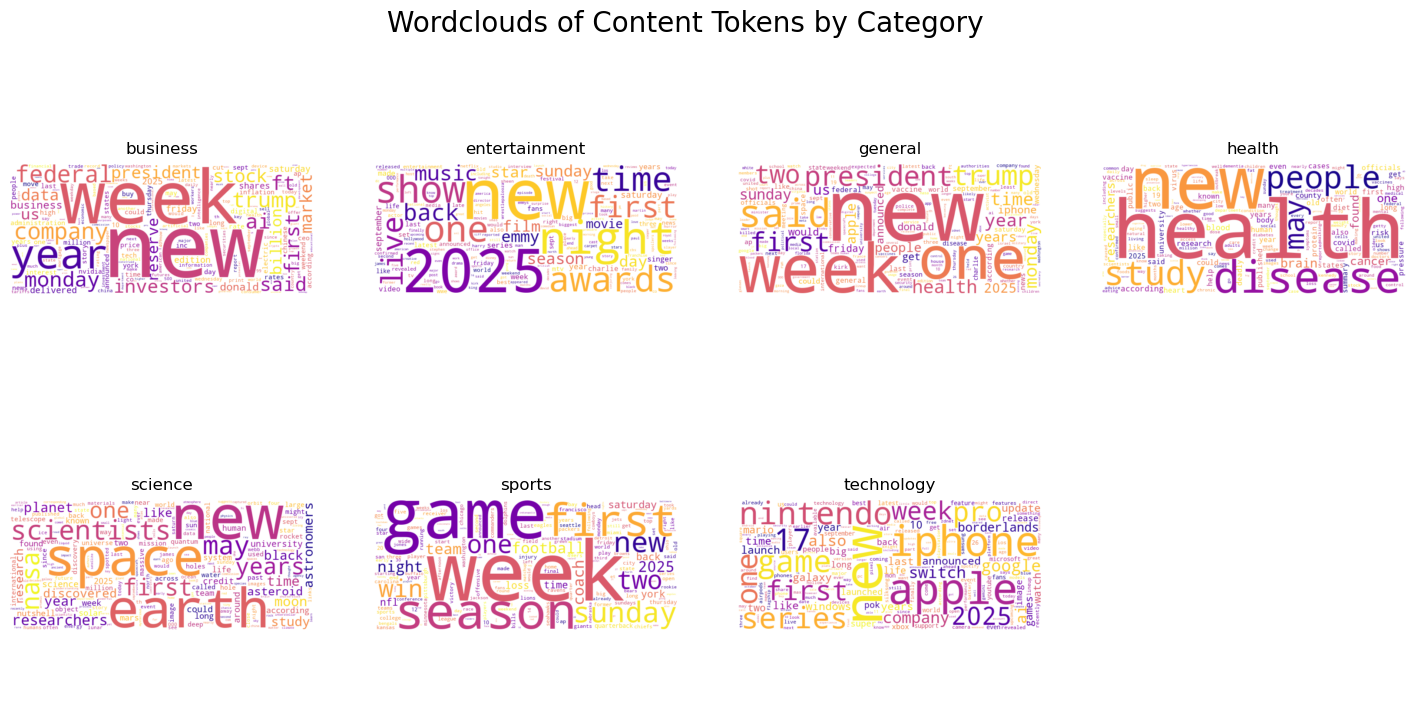

In [13]:
# Build out wordclouds for the content_tokens of each category.
# Config
MAX_WORDS = 200
MIN_TOKEN_LEN = 2
# pixel size passed to WordCloud
WIDTH, HEIGHT = 700, 300

# get categories (sorted for consistent layout)
categories = sorted(df['category'].dropna().unique().tolist())

# prepare subplots: 2 rows x 4 cols
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()  # flatten to 1D index

# for loop through the list of categories
for i, cat in enumerate(categories):
    # set axis for category
    ax = axes[i]
    # aggregate tokens for content_tokens category
    tokens_series = df.loc[df['category'] == cat, 'content_tokens']
    freq = Counter()
    for toks in tokens_series:
        if isinstance(toks, list):
            # light filter for readability
            freq.update([t for t in toks if isinstance(t, str) and len(t) >= MIN_TOKEN_LEN])
    # subplot formatting
    ax.set_title(str(cat), fontsize=12, pad=8)
    ax.axis("off")
    # handle the empty cases
    if len(freq) == 0:
        ax.text(0.5, 0.5, "No tokens", ha="center", va="center", fontsize=12)
        continue

    # create the wordcloud itself
    wc = WordCloud(
        width=WIDTH,
        height=HEIGHT,
        background_color="white",
        colormap="plasma",
        max_words=MAX_WORDS,
        normalize_plurals=True
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")

# hide any unused axes
for j in range(len(categories), 8):
    axes[j].axis("off")

fig.suptitle("Wordclouds of Content Tokens by Category", fontsize=20)
plt.show()

## Classification model

In [6]:
# train and test split
RANDOM_STATE = 42  # reproducibility

# building input text by concatenating fields, avoids NaNs and adds signal
text = (df['title'].fillna('') + ' ' +
        df['description'].fillna('') + ' ' +
        df['content'].fillna(''))

#categorical target
y = df['category'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(len(X_train), len(X_test))

2912 728


## Metrics and confusion matrix

In [7]:
# TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)  # fit on train
X_test_tfidf  = tfidf.transform(X_test)       # transform test only

Accuracy: 0.743
Macro-F1: 0.689

Classification report:
                precision    recall  f1-score   support

     business       0.64      0.80      0.71       120
entertainment       0.80      0.63      0.70        68
      general       0.50      0.12      0.20        72
       health       0.74      0.83      0.78       122
      science       0.75      0.85      0.79       123
       sports       0.81      0.95      0.87       128
   technology       0.84      0.71      0.77        95

     accuracy                           0.74       728
    macro avg       0.72      0.70      0.69       728
 weighted avg       0.73      0.74      0.72       728



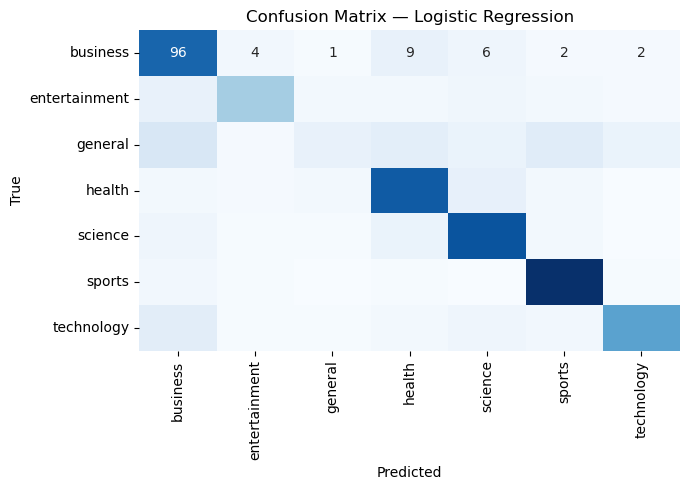

In [9]:
# Logistic Regression model
lr = LogisticRegression(max_iter=600, random_state=42)
lr.fit(X_train_tfidf, y_train)

# predict
y_pred = lr.predict(X_test_tfidf)

# metrics 
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Macro-F1:", round(f1_score(y_test, y_pred, average="macro"), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# confusion matrix 
labels = y_test.cat.categories if isinstance(y_test, pd.Series) and str(y_test.dtype).startswith("category") \
         else sorted(pd.Series(y_test).unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

C:\Users\annas\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Accuracy: 0.762
SVM Macro-F1: 0.726

SVM Classification report:
                precision    recall  f1-score   support

     business       0.70      0.77      0.73       120
entertainment       0.73      0.76      0.75        68
      general       0.41      0.26      0.32        72
       health       0.85      0.84      0.84       122
      science       0.82      0.83      0.82       123
       sports       0.84      0.93      0.88       128
   technology       0.75      0.73      0.74        95

     accuracy                           0.76       728
    macro avg       0.73      0.73      0.73       728
 weighted avg       0.75      0.76      0.75       728



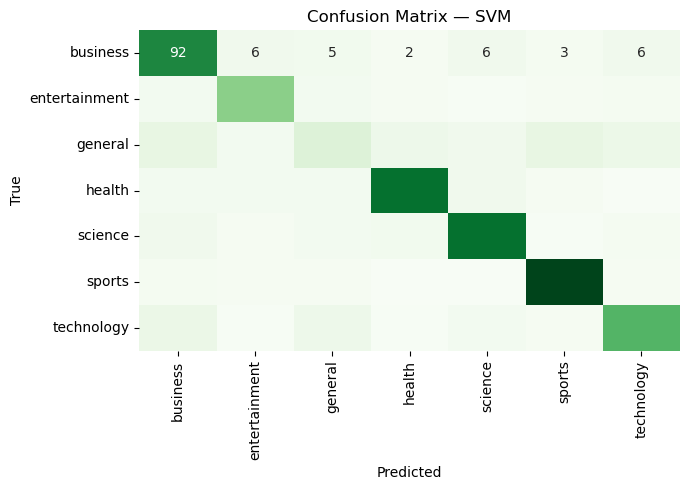

In [10]:
# SVM
svm = LinearSVC(random_state=42)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", round(accuracy_score(y_test, y_pred_svm), 3))
print("SVM Macro-F1:", round(f1_score(y_test, y_pred_svm, average='macro'), 3))
print("\nSVM Classification report:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plt.figure(figsize=(7,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — SVM")
plt.tight_layout()
plt.show()